<a href="https://colab.research.google.com/github/b4435242/hardware-security/blob/main/dpa_hiding_time_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from google.colab import drive
from scipy.spatial.distance import hamming
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/Shared/hwb/lab03/SC_python_measurement')

In [3]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')


def hamming_distance_matrix(matrix1, matrix2):
    # ensure the two matrices have the same shape
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    # initialize the distance matrix
    distance_matrix = np.zeros(matrix1.shape)

    # iterate over the rows and columns of the matrices
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            # calculate the Hamming distance between the elements at the same position
            r = (1 << np.arange(8))[:,None]
            distance_matrix[i, j] = np.count_nonzero(matrix1[i, j]&r != matrix2[i, j]&r)

    return distance_matrix


# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

def trace_compression(traces, num):
  return scipy.signal.resample(traces, num, axis=1)
  
def trace_alignment(traces):
  first_trace = traces[0]
  lags = []
  for i, trace in enumerate(traces):
    cross_corr = scipy.signal.correlate(first_trace, trace)
    lag = np.argmax(cross_corr) - (trace.shape[0]+1)
    lags.append(lag)
  # Set traces aligned to the most left point
  print(lags)
  most_left = min(lags)
  for i, trace in enumerate(traces):
    shift = lags[i] - most_left
    traces[i] = np.pad(trace[shift:], (0, shift), mode='constant') #shift and pad 0 at the end

  return traces

def trace_integration(traces, k):
  _traces = np.zeros((traces.shape[0], traces.shape[1]-k))
  for i, trace in enumerate(traces):
    trace_integrated = np.zeros(trace.shape[0]-k)
    sum = 0
    for j in range(0, k+1):
      sum += trace[j]
    trace_integrated[0] = sum
    for j in range(k+1, trace.shape[0]):
      sum += trace[j]
      sum -= trace[j-k-1]
      trace_integrated[j-k] = sum
    _traces[i] = trace_integrated
  return _traces    


In [4]:
def data_no_trigger():
  # read plaintext inputs
  inputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/plaintext.txt")

  # read length of one complete trace (number of samples per trace)
  with open("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/traceLength.txt", "r") as fin:
    trace_length = int(fin.readline())


  # trim each trace - select interesting part
  start = 90000
  len = 190000 # CHANGE to the length of the first round; 

  # read traces from binary file
  raw_traces = np.fromfile("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/traces.bin", dtype='uint8') # read as linear array
  raw_traces = np.reshape(raw_traces, (raw_traces.size // trace_length, trace_length)) # reshape into matrix
  raw_traces = raw_traces[:, 100000:-100000] # select only the interesting part of each trace
  return inputs, trace_length, raw_traces

def data_time_delay():
  # read plaintext inputs
  inputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/plaintext.txt")

  # read length of one complete trace (number of samples per trace)
  with open("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traceLength.txt", "r") as fin:
    trace_length = int(fin.readline())


  # trim each trace - select interesting part
  start = 100000
  end = 200000 # CHANGE to the length of the first round; 

  # read traces from binary file
  raw_traces = np.fromfile("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traces.bin", dtype='uint8') # read as linear array
  raw_traces = np.reshape(raw_traces, (raw_traces.size // trace_length, trace_length)) # reshape into matrix
  raw_traces = raw_traces[:, start:end] # select only the interesting part of each trace
  return inputs, trace_length, raw_traces


In [5]:
inputs, trace_length, raw_traces = data_time_delay()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00


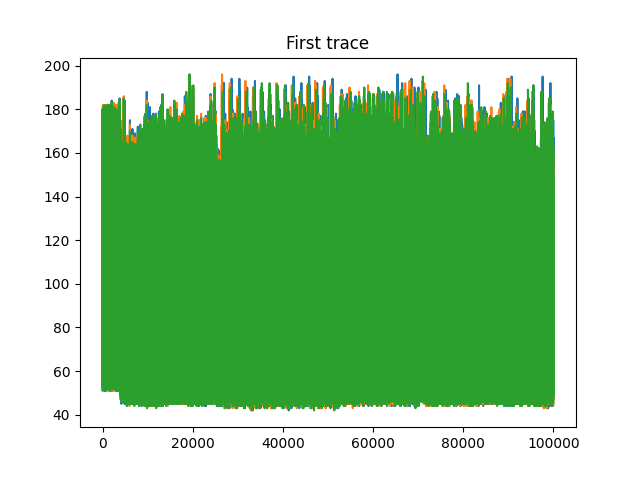

In [6]:
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
fig=plt.figure()
plt.plot(raw_traces[[0, 99, 199]].T) # plotting a vector
plt.title("First trace")
plt.show()

In [7]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(raw_traces.shape) # dimensions of matrix of traces

(1000, 16)
820000
(1000, 100000)


In [24]:

traces_compressed = trace_compression(raw_traces, 2000)
#print(traces_compressed.shape)
traces_integrated = trace_integration(traces_compressed, 50)

#traces_integrated = trace_integration(raw_traces, 100)
print(traces_integrated)
#traces_aligned = trace_alignment(traces_compressed)
#traces_aligned = trace_alignment(raw_traces)
#traces_aligned = trace_alignment(traces_integrated)

#print(traces_aligned.shape)
traces = traces_integrated

[[4567.21341697 4563.90785404 4563.92856891 ... 4198.34604712
  4197.84873828 4203.16972988]
 [4573.33560888 4570.89248887 4569.406863   ... 4196.24080526
  4206.47879066 4219.55514708]
 [4568.53780523 4568.17578381 4567.74737161 ... 4201.97235689
  4203.30927745 4210.01129466]
 ...
 [4559.39688167 4560.11309434 4557.5278199  ... 4215.31699527
  4224.85440665 4229.34865896]
 [4576.46152022 4574.29774001 4573.55485129 ... 4190.99112533
  4199.15515957 4211.79718242]
 [4569.76027337 4565.02719019 4563.84280663 ... 4205.56982852
  4199.50454733 4201.56041421]]


In [9]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib widget

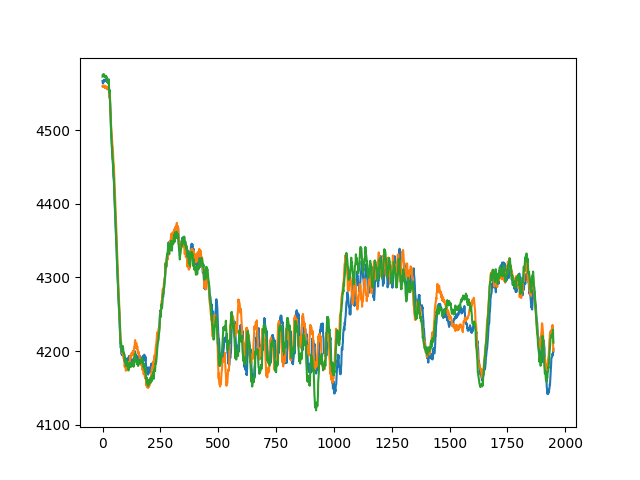

In [26]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[[0, 99, 199]].T)
plt.show()

In [11]:
traces = traces[:, :]

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [27]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [13]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [208  43 123 ... 111  98 135]
 [235 115  62 ...  93 246 144]
 [200 104  52 ... 154 124 187]]
(1000, 16)
(1000,)
(1000, 1)
(256,)
(1000, 256)
[[ 37  36  39 ... 216 219 218]
 [134 135 132 ... 123 120 121]
 [215 214 213 ...  42  41  40]
 ...
 [208 209 210 ...  45  46  47]
 [235 234 233 ...  22  21  20]
 [200 201 202 ...  53  54  55]]


In [28]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [15]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
def power_model(model, smat, xmat):
  if model=="hw":
    return hw_table[smat]
  elif model=="hd":
    return hamming_distance_matrix(smat, xmat)
  else:
    return smat

[[6 4 4 ... 3 5 5]
 [2 4 6 ... 2 5 5]
 [3 6 2 ... 5 4 3]
 ...
 [3 5 5 ... 4 3 3]
 [5 4 4 ... 4 4 6]
 [4 6 4 ... 4 2 4]]
(1000, 256)
(1000, 1950)
max_acorr 0.250047
key: 1 time: 1450
key: , 01


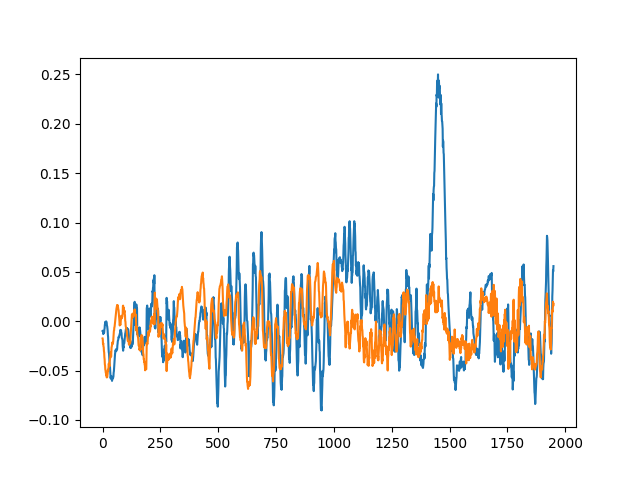

[[3. 2. 6. ... 5. 3. 4.]
 [3. 2. 6. ... 4. 3. 6.]
 [5. 1. 5. ... 6. 3. 3.]
 ...
 [2. 7. 5. ... 6. 5. 4.]
 [1. 5. 7. ... 3. 3. 6.]
 [1. 2. 6. ... 4. 4. 5.]]
(1000, 256)
(1000, 1950)
max_acorr 0.136986
key: 165 time: 548
key: ¥, a5


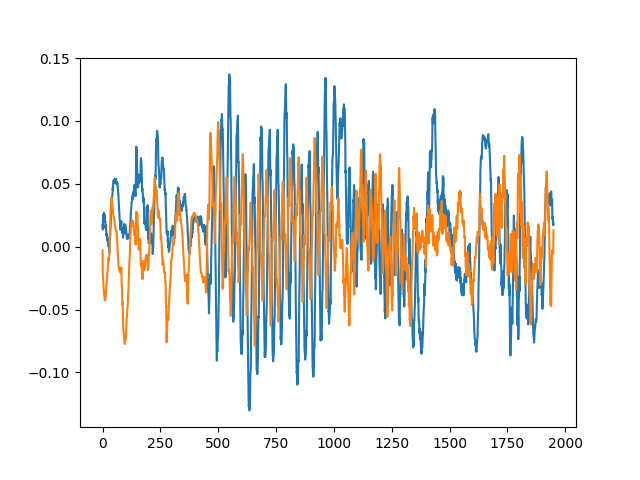

[[ 63  54 204 ...  97 185  87]
 [ 68  23  95 ...  33 188 182]
 [ 14 246   3 ... 229 165  52]
 ...
 [112  62 181 ... 216  49  21]
 [233 135  30 ...  71  89 250]
 [232 221 116 ... 150   5 154]]
(1000, 256)
(1000, 1950)
max_acorr 0.158686
key: 246 time: 1194
key: ö, f6


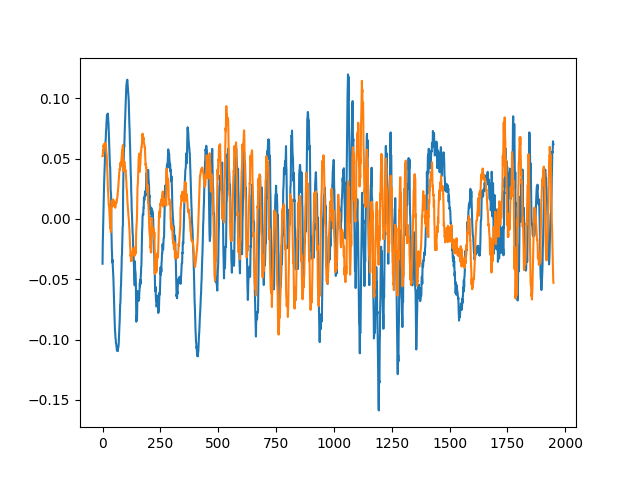

In [29]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
models = ["hw", "hd", "byte"]
for model in models:
  mat = power_model(model, smat, xmat)
  print(mat)
  print(mat.shape)
  print(traces.shape)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  print("max_acorr %f" % max_acorr)
  print("key: %d time: %d" % (k[0], j[0]))
  print("key: %1c, %02x" % (k[0], k[0]))
  # Plot the correlation traces for the right key byte guess and one wrong key byte guess
  # Do you see the correlation peaks?
  fig = plt.figure()
  plt.plot(corr[k[0]])
  plt.plot(corr[k[0]+1])
  plt.show()

## **Break all key bytes!**

In [30]:
def attack(inp, model):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  return k, j

In [18]:
print(inputs)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [208  43 123 ... 111  98 135]
 [235 115  62 ...  93 246 144]
 [200 104  52 ... 154 124 187]]


In [31]:
models = ["hw"]
kk = np.zeros(16, dtype='uint8')
for model in models:
  for i in range(0, 16):
      inp = inputs[:, i]
      k, j = attack(inp, model)
      kk[i] = k[0]
      print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
  print(kk)

, 01 @ 1450
#, 23 @ 1593
E, 45 @ 1551
g, 67 @ 1504
, 89 @ 1492
«, ab @ 1469
Í, cd @ 1590
ï, ef @ 1557
Ê, ca @ 1551
þ, fe @ 1511
º, ba @ 1446
¾, be @ 1629
Þ, de @ 1589
­, ad @ 1560
¾, be @ 1506
ï, ef @ 1450
[  1  35  69 103 137 171 205 239 202 254 186 190 222 173 190 239]


## **Verify the key on a PT, CT pair!**

In [32]:
key_bytes = bytes(kk)
outputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/ciphertext.txt")

In [33]:
!pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
msh = cipher.encrypt(bytes(inputs))
outputs = bytes(outputs)
print("Equal = {} \nct is {}\nencrypted pt is {}".format(outputs==msh ,outputs, msh))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Equal = True 
ct is b'\xc9\xae\xe3:\xb5<5w\xfa\xe9\xd1\x156\xfe\xff\xe2\x90X\x12)\xb7Z\xfbG\xad\x7f\xbb5\x85\xac\n\xc2\x9b\x12!+\xa1L\x95ww\xef\x8a\x97\xdd_SF\xcdO\x9c\x87>j\xbe\xb3J\xad\xa0\x03\xdcK\x8f\x9f\xce`Fq\xfb5!\\\x14V\xa7Dn\x80q\xa8\x1c\xd16p\xad~z\xe9*\xce\x1a]\xcc\xa7\xf6\x90\xb8G\xbeo\xd8@\xd5\xf2\xf7\xd5{\x14O\x82u`\xd9\x993\x1c\xdfE\x7f>V\xa2H\x10\x03\xb4+\xfd\xea\xa4\x8e\x196%KzNYa\x9b\x1d\x1b\xaa\x0b[\x16\xc3\x8d\xfd\xa6\xe8\x1e\x0b\xa4\xc8\xf3#\xd7<\xc9\x19\xb7\xaa\xfc\xd67\x8e\x1e&\xee7\x955\xc9\xe7\xc9\xbf\xea\x82\x89\xd8?:@\x9b\x84W\xe6\xbc\x0cK\x82\xe0\xa8}\xcc\xf1S\xb7\x87\x9d\x8d\x10\xe6\xe7\x8duh\xea\xea\x19\xbdWW\xdc\x9d\x88\x12\xc5\xbeF\xcb\xb5\xf2\xe1\xfe\x88\xff:6\x16[\xa3\xf2\x0f\xdb%Xe\x1e0aF\x16\xd1\xf1\xc9\xc9\xf1\xb5K\x05c\xf1\xe9\xbd\x90\x05\x1e\xa1W\x81`"\x04\xcaG\xc6\xfa_\x1f{$\x97\xea\xe2\xee\xb4O\xc2\xabV\xa8\xb4\xbc\xa8l\xd9X\xe42\x06\xf6\x8d\xf9\xa

## **PGE**

In [22]:
def PGE(inp, model, traces):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_corr_table = np.zeros(256)
  for i, corr_of_key in enumerate(acorr):
    max_corr_table[i] = corr_of_key.max()

  pge = max_corr_table.argsort()[::-1]
  return pge

  

In [23]:
traces_num = [50,100,200,500]
models = ["hw","hd","byte"]
for trace_num in traces_num:
  sub_traces = traces[:trace_num]
  sub_inputs = inputs[:trace_num]
  for model in models:
    for i in range(0, 16):
        inp = sub_inputs[:, i]
        pge_table = PGE(inp, model, sub_traces)
        pge = np.where(pge_table==kk[i])[0][0]
        print("PGE for {} round is {}".format(i, pge))
        #print(pge[0])



PGE for 0 round is 24
PGE for 1 round is 131
PGE for 2 round is 15
PGE for 3 round is 131
PGE for 4 round is 116
PGE for 5 round is 78
PGE for 6 round is 226
PGE for 7 round is 161
PGE for 8 round is 200
PGE for 9 round is 34
PGE for 10 round is 74
PGE for 11 round is 189
PGE for 12 round is 175
PGE for 13 round is 29
PGE for 14 round is 154
PGE for 15 round is 108
PGE for 0 round is 34
PGE for 1 round is 206
PGE for 2 round is 120
PGE for 3 round is 82
PGE for 4 round is 154
PGE for 5 round is 107
PGE for 6 round is 199
PGE for 7 round is 68
PGE for 8 round is 163
PGE for 9 round is 190
PGE for 10 round is 33
PGE for 11 round is 242
PGE for 12 round is 171
PGE for 13 round is 103
PGE for 14 round is 187
PGE for 15 round is 72
PGE for 0 round is 61
PGE for 1 round is 166
PGE for 2 round is 69
PGE for 3 round is 95
PGE for 4 round is 152
PGE for 5 round is 30
PGE for 6 round is 147
PGE for 7 round is 210
PGE for 8 round is 218
PGE for 9 round is 117
PGE for 10 round is 174
PGE for 11 ro